## 필요한 라이브러리 import 

In [24]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기 ( 모델 생성 : 캐글 데이터 활용 )
https://www.kaggle.com/rounakbanik/the-movies-dataset

In [26]:
movies = pd.read_csv('/content/drive/My Drive/추천 시스템 입문/data/ml-latest-small/tmdb_5000_movies.csv')
movies[['genres', 'id',  'original_title', 'vote_average', 'vote_count']]

,genres,id,original_title,vote_average,vote_count
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,Avatar,7.2,11800
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,Pirates of the Caribbean: At World's End,6.9,4500
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,Spectre,6.3,4466
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,The Dark Knight Rises,7.6,9106
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,John Carter,6.1,2124
...,...,...,...,...,...
4798,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",9367,El Mariachi,6.6,238
4799,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",72766,Newlyweds,5.9,5
4800,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",231617,"Signed, Sealed, Delivered",7.0,6
4801,[],126186,Shanghai Calling,5.7,7


## 데이터 전처리

### genres = ["Action",  "Adventure"]

In [27]:
movies['genres'] = movies['genres'].apply(literal_eval)
movies['keywords'] = movies['keywords'].apply(literal_eval)

In [28]:
movies['genres'] = movies['genres'].apply(lambda x : [d['name'] for d in x]).apply(lambda x : " ".join(x))
movies['keywords'] = movies['keywords'].apply(lambda x : [d['name'] for d in x]).apply(lambda x : " ".join(x))

In [29]:
m = movies['vote_count'].quantile(0.9)
movies = movies.loc[movies['vote_count'] >= m]
C = movies['vote_average'].mean()

## 가중치 조절 

https://www.quora.com/How-does-IMDbs-rating-system-work


In [30]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    
    return ( v / (v+m) * R ) + (m / (m + v) * C)


movies['score'] = movies.apply(weighted_rating, axis = 1)

## 비슷한 영화를 추천 하기 위해서 영화 간 유사도를 측정

### 이는 코사인 유사도를 이용해서 구함

In [31]:
count_vector = CountVectorizer(min_df=0, ngram_range=(1, 2))

In [32]:
genre_mat = count_vector.fit_transform(movies['genres'])

In [33]:
genre_mat.shape

(481, 146)

In [34]:
gerne_c_sim = cosine_similarity(genre_mat, genre_mat)

In [35]:
gerne_c_sim.shape

(481, 481)

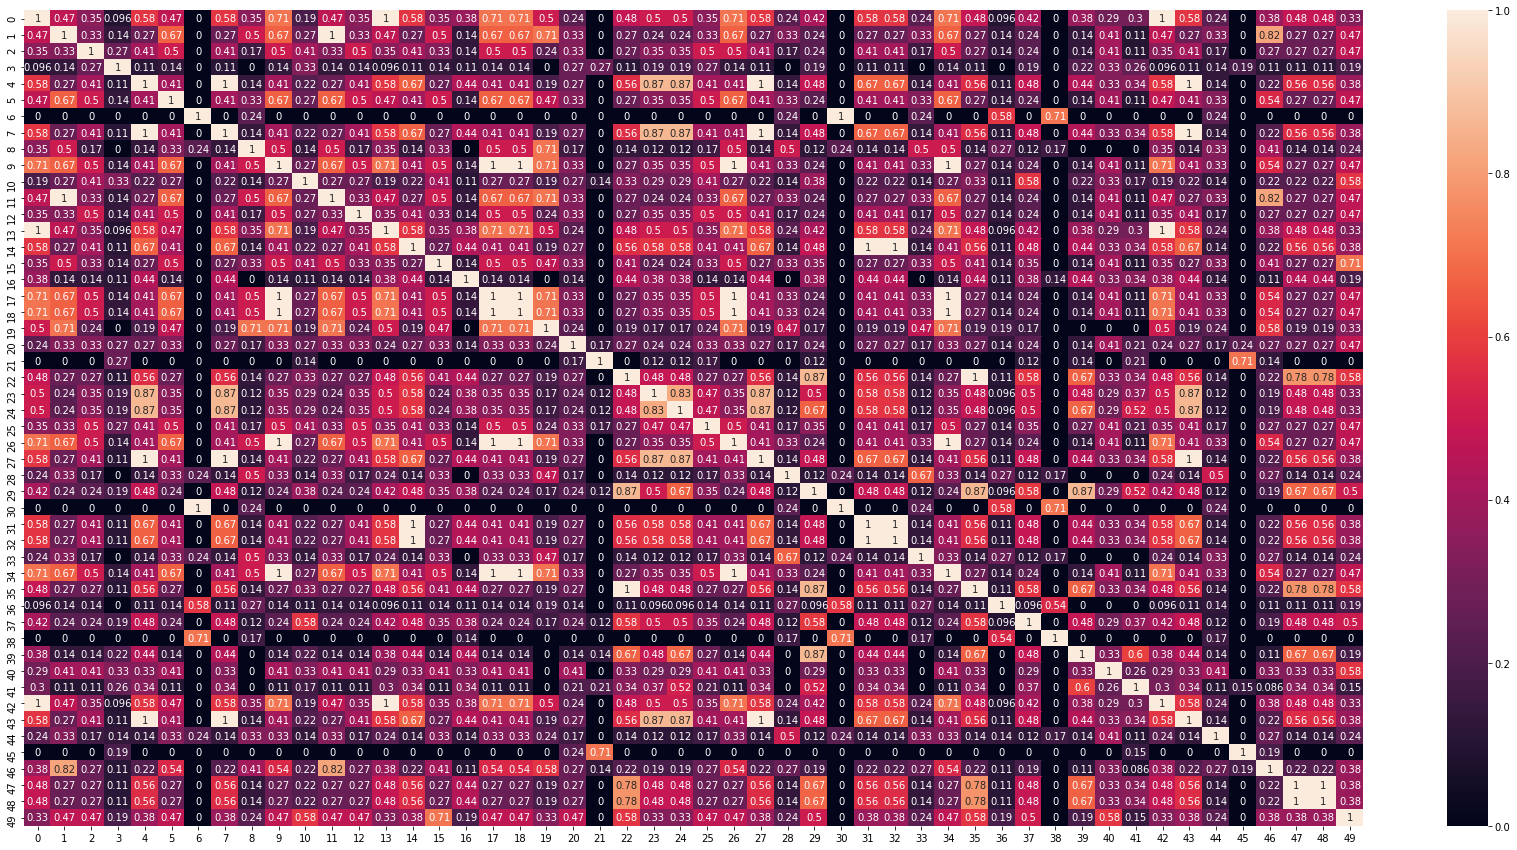

In [39]:
plt.figure(figsize=(30, 15))
sns.heatmap(gerne_c_sim[:50, :50], annot=True)

### 비슷한 영화를 추천 하는 함수 

In [37]:
def get_recommend_movie_list(df, movie_title, top=10):
    target_movie_index = df[df['title'] == movie_title].index.values
    sim_index = gerne_c_sim[target_movie_index, :top].reshape(-1)
    sim_index = sim_index[sim_index != target_movie_index] # 입력으로 하는 영화는 제외시키고 다른것을 추천
    result = df.iloc[sim_index].sort_values('score', ascending=False)[:10]
    return result

In [38]:
get_recommend_movie_list(movies, "Frozen")

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,score
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.168053
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.168053
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.168053
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.168053
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.168053
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.168053
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.168053
0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Rel